- Dados: Focos de calor do INPE na frequência anual - https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_sat_ref/
- Código realizado por: Enrique V. Mattos - 22/05/2024

# **1° Passo:** Instalando as bibliotecas

In [ ]:
# Instalando matplotlib, proplot e numpy
!pip install -q matplotlib==3.4.3
!pip install -q proplot==0.9.7
!pip install -q numpy==1.24.3

# Instalando salem
!pip install -q salem==0.3.9

# Instalando Xarray e suas dependências: https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
!pip install -q xarray dask netCDF4 bottleneck

# Instalando rasterio, pyproj e geopandas
!pip install -q rasterio pyproj geopandas

# Instalando cartopy
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy

Found existing installation: shapely 2.0.4
Uninstalling shapely-2.0.4:
  Successfully uninstalled shapely-2.0.4


- Chegando aqui, será necessário fazer a `Reinicialização do Ambiente de Execução`. Para isto, você deverá acessar `Ambiente de execução`, localizado na barra de ferramentas e clicar em `Reiniciar Sessão`. Como indicado na imagem abaixo.

- Em seguida você deverá rodar novamente a célula anterior de instalações, de forma que as bibliotecas sejam instaladas novamente.

- Isso é necessário tanto para poder usar sem problemas o `Proplot` na nossa sessão do Colab. Então a partir desse ponto não teremos mais que nos preocupar com a preparação do ambiente virtual.

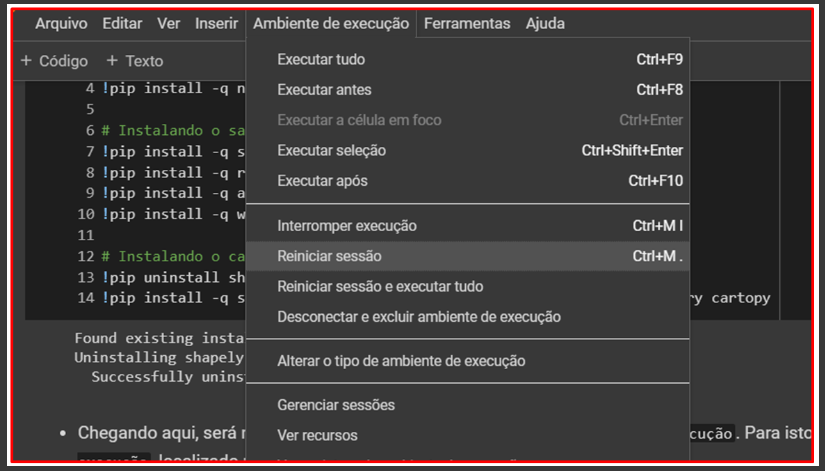

# **2° Passo:** Importando bibliotecas

In [ ]:
import numpy as np
import proplot as pplt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from zipfile import ZipFile
import salem
from datetime import datetime
import glob
import xarray as xr
import os
import cartopy.crs as ccrs

# vamos ignorar vários avisos
import warnings
warnings.filterwarnings('ignore')

# **3° Passo:** Monta drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/5_EXTENSAO/01_prefeitura_analise_periodo_chuvoso_2023_2024/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **4° Passo:** Carrega shapefile

In [ ]:
# leitura do shapefile do Brasil
shapefile_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')

# **PARTE 1):** Leitura dos dados de focos de calor

##Baixando os dados

In [ ]:
#==============================================================#
#                         2003 à 2023
#==============================================================#
# Exemplo: focos_br_ref_2003.zip

# ano inicial de final
anoi, anof = '2003','2024'

# ftp dos dados anual do satélite AQUA
url = f'https://dataserver-coids.inpe.br/queimadas/queimadas/focos/csv/anual/Brasil_sat_ref/'

# loop dos meses
ano_mesi = f'{anoi}0101'
ano_mesf = f'{anof}1201'

for data in pd.date_range(ano_mesi, ano_mesf, freq='1Y'):

    # estrai ano e mês
    ano = data.strftime('%Y')
    mes = data.strftime('%m')

    # baixa o arquivo
    filename = f'{url}focos_br_ref_{ano}.zip'
    !wget {filename}
    print(ano)

##Lendo os dados

In [ ]:
%%time
# lista os arquivos
files = sorted(glob.glob('/content/focos_br_ref*.zip'))

# loop de cada arquivo da lista "files"
df = pd.DataFrame()
for file in files:

    # nome do arquivo
    basename = os.path.basename(os.path.splitext(file)[0])
    print('Processando ===>>>>', basename)

    # extrai a data da imagem
    ano = basename[13:17]

    # leitura da tabela
    df0 = pd.read_csv(file, compression='zip')

    # renomeia coluna
    df0.rename(columns={'data_pas': 'data', 'latitude': 'lat', 'longitude': 'lon'}, inplace=True)

    # reposiciona as colunas
    df0 = df0[['data', 'lat', 'lon', 'municipio', 'estado', 'bioma']]

    # junta a tabela que foi lida com a anterior
    df = pd.concat([df, df0], ignore_index=True)

# transforma a coluna "data" para o formato "datetime"
df['data'] = pd.to_datetime(df['data'])

# seta a coluna "data_hora_gmt" como o índice da tabela
df.set_index('data', inplace=True)

# mostra o dataframe
df.head(2)

# **PARTE 2):** Processamento

## Função

In [ ]:
# Função que calcula o índice i e j da localização do foco
def index(longitudes_matriz, latitudes_matriz, lon_foco, lat_foco):

    ''' Função para calcular o índice (i e j) do pixel de uma matriz que o relâmpago pertence

    Parâmetros:
               longitudes_matriz (array): array de uma dimensão das longitudes da matriz em graus
               latitudes_matriz (array): array de uma dimensão das latitudes da matriz em graus
               lon_raio (float): valor da longitude do foco em graus
               lat_raio (float): valor da latitude do foco em graus

    Retorna:
            indice_lat_raio (float): índice da latitude (ou seja, da linha) do pixel da matriz que o foco pertence
            indice_lon_raio (float): índice da longitude (ou seja, da coluna) do pixel da matriz que o foco pertence
    '''

    # calcula a diferença entre as lats/lons da matriz e a latitude/longitude do foco
    distancia_lon = (longitudes_matriz - lon_foco)**2
    distancia_lat = (latitudes_matriz - lat_foco)**2

    # índice da longitude e latitude do foco
    indice_lon_foco = np.nonzero(distancia_lon == np.min(distancia_lon))
    indice_lat_foco  = np.nonzero(distancia_lat == np.min(distancia_lat))

    # retorna os valores dos índices calculados
    return indice_lat_foco, indice_lon_foco

## Acumula na grade

In [ ]:
%%time
# Limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# Espaçamento da grade
delta = 20/100.   # grade com 20 km de resolução espacial

# Montando a grade
lons = np.arange(lonmin, lonmax, delta)
lats = np.arange(latmax, latmin, -delta)

# Quantidade de pontos para longitude e latitude
nlon = len(lons)
nlat = len(lats)

# Loop dos anos
for ano in np.arange(2003,2024):

    print('Processando ===>>>', ano)

    # seleciona o mês
    df_selec = df.loc[f'{str(ano)}']

    # gera matriz de raios
    focos_lon, focos_lat = df_selec['lon'].values, df_selec['lat'].values

    # interpolando para ponto de grade
    focos = np.zeros((nlat, nlon))

    # loop em cada longitude e latitude da lista
    for lonfoco, latfoco in zip(focos_lon, focos_lat):

        # função que extrai a qual pixel aquele relâmpago pertence
        lin, col = index(lons, lats, lonfoco, latfoco)

        # soma os relâmpagos por pixel
        focos[lin,col]+=1

    # gera arquivo netcdf
    data_vars = {'focos':(('lat', 'lon'), focos, {'units': 'ocorrências/400km²', 'long_name':'Focos de Calor'})}
    coords = {'lat': lats, 'lon': lons, 'time': pd.to_datetime(f'{str(ano)}-12')}
    ds = xr.Dataset(data_vars=data_vars, coords=coords)
    ds.to_netcdf(f'{dir}output/01_FOCOS_CALOR/focos_anual_brasil_AQUA_{ano}.nc')

    print('Máximo do Brasil', np.max(focos), '\n', 'Máximo do Estado', np.sum(focos), '\n')

Processando ===>>> 2003
Máximo do Brasil 413.0 
 Máximo do Estado 341237.0 

Processando ===>>> 2004
Máximo do Brasil 460.0 
 Máximo do Estado 380445.0 

Processando ===>>> 2005
Máximo do Brasil 469.0 
 Máximo do Estado 362563.0 

Processando ===>>> 2006
Máximo do Brasil 316.0 
 Máximo do Estado 249179.0 

Processando ===>>> 2007
Máximo do Brasil 456.0 
 Máximo do Estado 393915.0 

Processando ===>>> 2008
Máximo do Brasil 249.0 
 Máximo do Estado 211933.0 

Processando ===>>> 2009
Máximo do Brasil 325.0 
 Máximo do Estado 155102.0 

Processando ===>>> 2010
Máximo do Brasil 338.0 
 Máximo do Estado 319383.0 

Processando ===>>> 2011
Máximo do Brasil 194.0 
 Máximo do Estado 158099.0 

Processando ===>>> 2012
Máximo do Brasil 430.0 
 Máximo do Estado 217234.0 

Processando ===>>> 2013
Máximo do Brasil 168.0 
 Máximo do Estado 128145.0 

Processando ===>>> 2014
Máximo do Brasil 301.0 
 Máximo do Estado 175892.0 

Processando ===>>> 2015
Máximo do Brasil 380.0 
 Máximo do Estado 216778.0 


In [ ]:
xr.open_dataset(f'{dir}output/01_FOCOS_CALOR/focos_anual_brasil_AQUA_2023.nc')

<xarray.Dataset>
Dimensions:  (lat: 210, lon: 210)
Coordinates:
  * lat      (lat) float64 7.0 6.8 6.6 6.4 6.2 ... -34.0 -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 -75.0 -74.8 -74.6 -74.4 ... -33.8 -33.6 -33.4 -33.2
    time     datetime64[ns] ...
Data variables:
    focos    (lat, lon) float64 ...

## Agrupa os dados

In [ ]:
# define ano
ano = '2023'

# lista dos arquivos
files = sorted(glob.glob(f'{dir}output/01_FOCOS_CALOR/focos_anual_brasil_*.nc')) # focos_anual_brasil_AQUA_2023.nc

# leitura dos arquivos por ano
focos_por_ano = xr.open_mfdataset(files, concat_dim='time', combine='nested')

# coloca "NaN" onde os "focos=0"
condicao = focos_por_ano['focos'][:,:,:] == 0
focos_por_ano['focos'][:,:,:] = np.where(condicao, np.nan, focos_por_ano['focos'][:,:,:])

# calculando a CLIMATOLOGIA: 2003-2022
climatologia = focos_por_ano.sel(time=slice('2003-01-01','2022-12-31')).mean("time")

# calculando a ANOMALIA: 2023
anomalia = focos_por_ano['focos'].sel(time=slice(ano,ano))[0,:,:] - climatologia

# recorta o dado para região
anomalia = anomalia.salem.roi(shape=shapefile_brasil)
climatologia = climatologia.salem.roi(shape=shapefile_brasil)

In [ ]:
focos_por_ano.sel(time=slice('2003-01-01','2022-12-31'))

<xarray.Dataset>
Dimensions:  (time: 20, lat: 210, lon: 210)
Coordinates:
  * lat      (lat) float64 7.0 6.8 6.6 6.4 6.2 ... -34.0 -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 -75.0 -74.8 -74.6 -74.4 ... -33.8 -33.6 -33.4 -33.2
  * time     (time) datetime64[ns] 2003-12-01 2004-12-01 ... 2022-12-01
Data variables:
    focos    (time, lat, lon) float64 dask.array<chunksize=(1, 210, 210), meta=np.ndarray>

In [ ]:
focos_por_ano['focos'].sel(time=slice(ano,ano))

<xarray.DataArray 'focos' (time: 1, lat: 210, lon: 210)>
dask.array<getitem, shape=(1, 210, 210), dtype=float64, chunksize=(1, 210, 210), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 7.0 6.8 6.6 6.4 6.2 ... -34.0 -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 -75.0 -74.8 -74.6 -74.4 ... -33.8 -33.6 -33.4 -33.2
  * time     (time) datetime64[ns] 2023-12-01
Attributes:
    units:      ocorrências/400km²
    long_name:  Focos de Calor

In [ ]:
focos_por_ano['focos'].sel(time=slice(ano,ano))[0,:,:]

<xarray.DataArray 'focos' (lat: 210, lon: 210)>
dask.array<getitem, shape=(210, 210), dtype=float64, chunksize=(210, 210), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 7.0 6.8 6.6 6.4 6.2 ... -34.0 -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 -75.0 -74.8 -74.6 -74.4 ... -33.8 -33.6 -33.4 -33.2
    time     datetime64[ns] 2023-12-01
Attributes:
    units:      ocorrências/400km²
    long_name:  Focos de Calor

In [ ]:
# mostra os dados
focos_por_ano

<xarray.Dataset>
Dimensions:  (time: 21, lat: 210, lon: 210)
Coordinates:
  * lat      (lat) float64 7.0 6.8 6.6 6.4 6.2 ... -34.0 -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 -75.0 -74.8 -74.6 -74.4 ... -33.8 -33.6 -33.4 -33.2
  * time     (time) datetime64[ns] 2003-12-01 2004-12-01 ... 2023-12-01
Data variables:
    focos    (time, lat, lon) float64 dask.array<chunksize=(1, 210, 210), meta=np.ndarray>

In [ ]:
# climatologia
climatologia

<xarray.Dataset>
Dimensions:  (lat: 210, lon: 210)
Coordinates:
  * lat      (lat) float64 7.0 6.8 6.6 6.4 6.2 ... -34.0 -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 -75.0 -74.8 -74.6 -74.4 ... -33.8 -33.6 -33.4 -33.2
Data variables:
    focos    (lat, lon) float64 dask.array<chunksize=(210, 210), meta=np.ndarray>
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [ ]:
# mostra os dados
anomalia

<xarray.Dataset>
Dimensions:  (lat: 210, lon: 210)
Coordinates:
  * lat      (lat) float64 7.0 6.8 6.6 6.4 6.2 ... -34.0 -34.2 -34.4 -34.6 -34.8
  * lon      (lon) float64 -75.0 -74.8 -74.6 -74.4 ... -33.8 -33.6 -33.4 -33.2
    time     datetime64[ns] 2023-12-01
Data variables:
    focos    (lat, lon) float64 dask.array<chunksize=(210, 210), meta=np.ndarray>
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

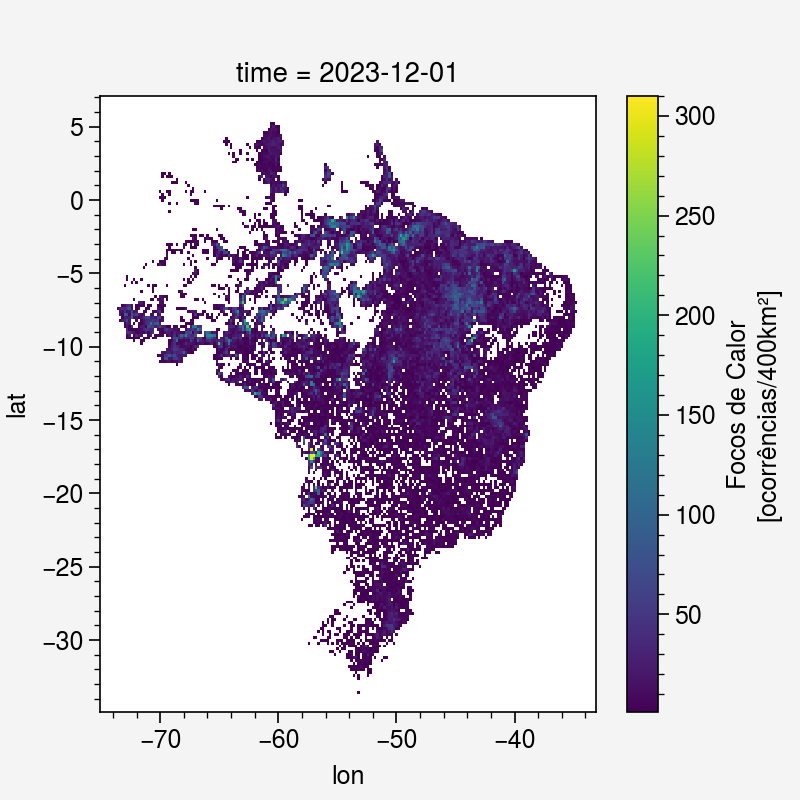

In [ ]:
focos_por_ano['focos'][20,:,:].plot()

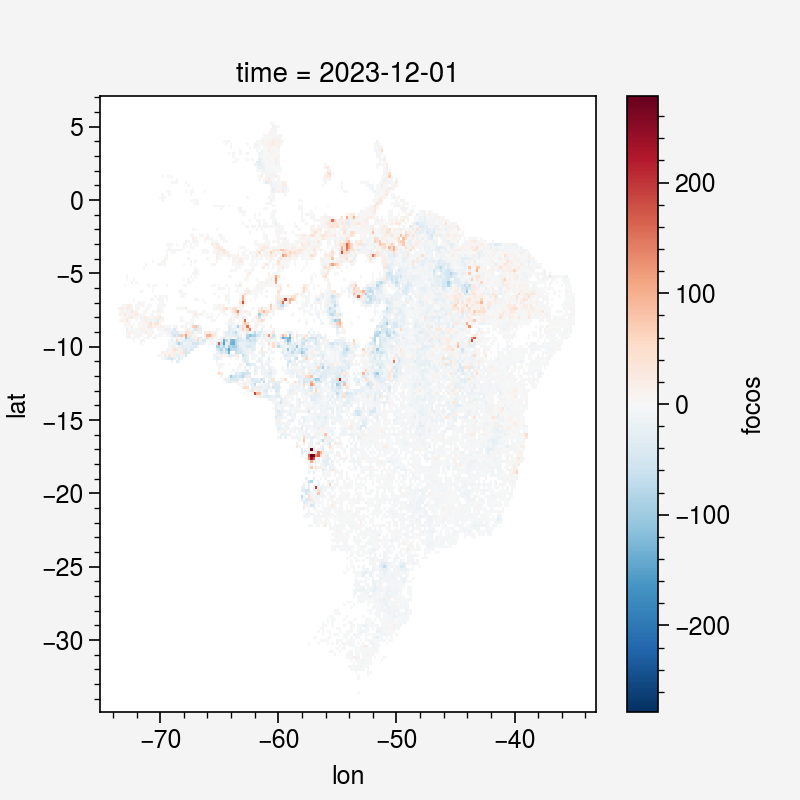

In [ ]:
anomalia['focos'][:,:].plot()

# **PARTE 3):** Plota figuras individuais - `MAPA DE DENSIDADE`

CPU times: user 20.3 s, sys: 1.98 s, total: 22.2 s
Wall time: 26.5 s


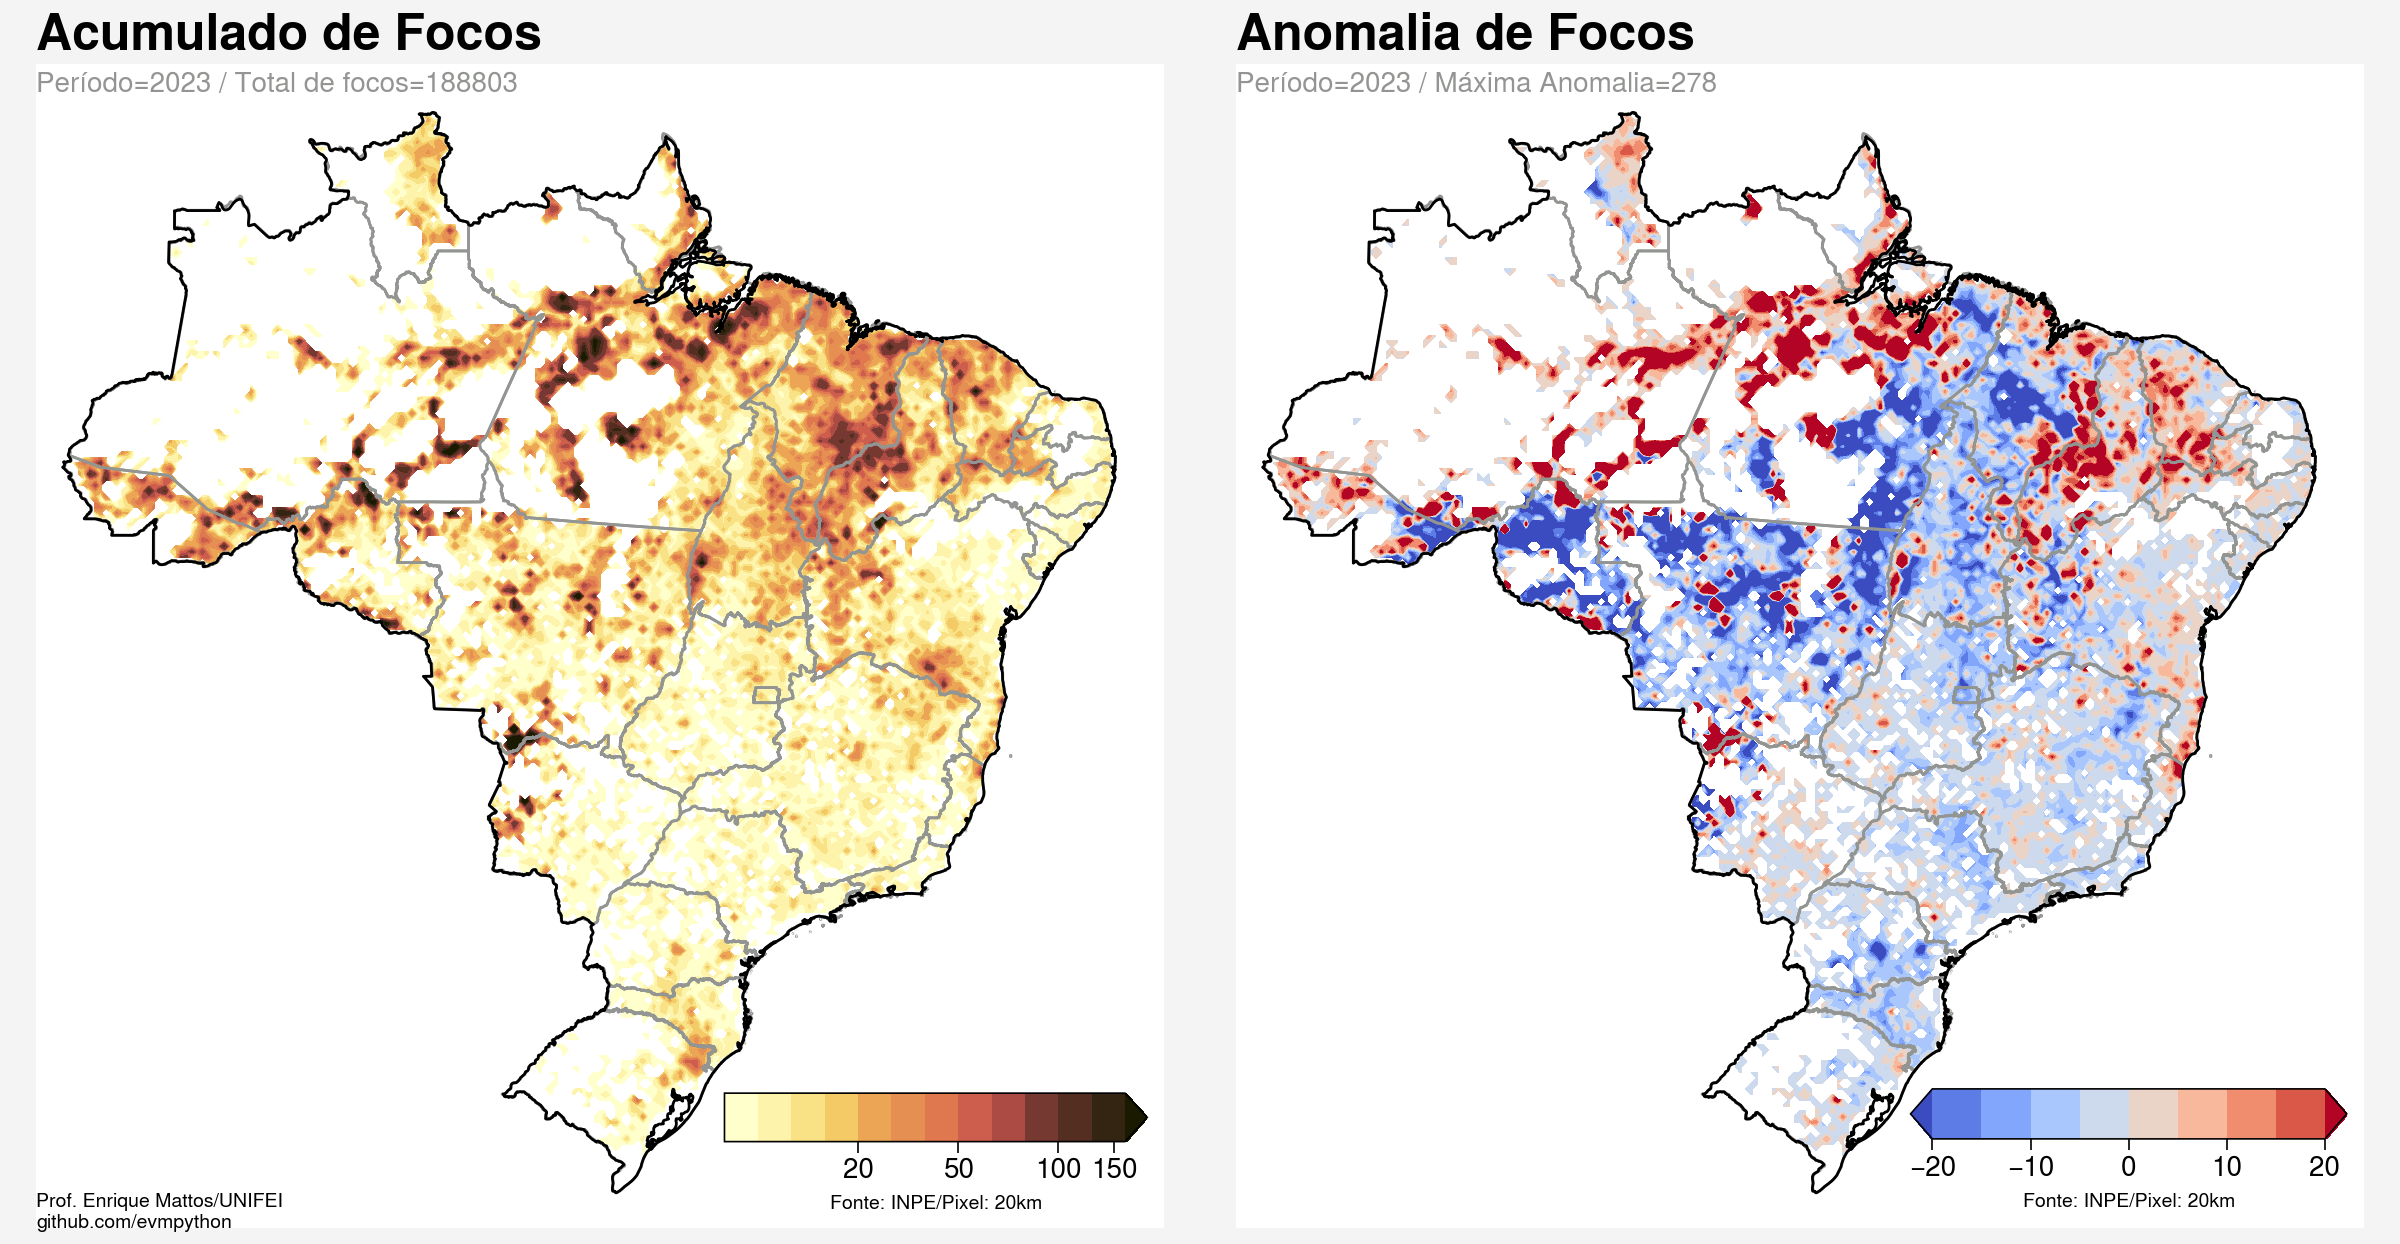

In [ ]:
%%time
#========================================================================================================================#
#                                           PLOTA FIGURA
#========================================================================================================================#
# cria a moldura da figura
fig, ax = pplt.subplots(axwidth=6, ncols=2, nrows=1, tight=True, proj='pcarree')

# limites do Brasil
lonmin, lonmax, latmin, latmax = -75.0, -33.0, -35.0, 7.0

# define formato da figura
ax.format(coast=False, borders=False, innerborders=False,
          labels=False, latlines=5, lonlines=10,
          latlim=(latmin, latmax), lonlim=(lonmin, lonmax),
          small='20px', large='25px',
          linewidth=0, grid=False)

#--------------------------------------------------------------#
#                            FIG-1
#--------------------------------------------------------------#
# plota mapa
map1 = ax[0].contourf(focos_por_ano['lon'],
                      focos_por_ano['lat'],
                      focos_por_ano['focos'].loc[f'{ano}-12-01'].salem.roi(shape=shapefile_brasil),
                      cmap='lajolla',
                      vmin=0, vmax=160,
                      levels=np.array([0, 5, 10, 15, 20, 30, 40, 50, 60, 70, 100, 130, 160]),
                      extend='max',
                      colorbar='best',
                      colorbar_kw={'label': 'Fonte: INPE/Pixel: 20km',
                                   'length': 18,
                                   'frameon': False,
                                   'ticklabelsize': 10,
                                   'labelsize': 7,
                                   'width': 2,
                                   'ticks': [20, 50, 100, 150],
                                   'ticklabels': ['20', '50', '100', '150']})

# exemplo: https://matplotlib.org/3.4.3/gallery/ticks_and_spines/colorbar_tick_labelling_demo.html
#ticks=[-1, 0, 1]
# yticklabels(['< -1', '0', '> 1'])
# 'ticks': 50}

# título da figura
ax[0].format(title=f'Acumulado de Focos',
             titleloc='l',
             titleweight='bold',
             titlecolor='black')

# plota subtítulo
total = focos_por_ano['focos'].loc[f'{ano}-12-01'].salem.roi(shape=shapefile_brasil)
total = int(np.sum(total))
ax[0].text(lonmin, latmax-1.0, f'Período={ano} / Total de focos={total}', color='grey', fontsize=10)

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[0])

# informação na figura
ax[0].annotate('Prof. Enrique Mattos/UNIFEI\ngithub.com/evmpython', xy=(lonmin,latmin), fontsize=7, color='black')

#--------------------------------------------------------------#
#                            FIG-2
#--------------------------------------------------------------#
ax[1].contourf(anomalia['lon'],
               anomalia['lat'],
               anomalia['focos'][:,:],
               cmap='coolwarm',
               vmin=-20, vmax=20,
               levels=pplt.arange(-20, 20, 5),
               extend='both',
               colorbar='best',
               colorbar_kw={'label': 'Fonte: INPE/Pixel: 20km',
                            'length': 18,
                            'frameon': False,
                            'ticklabelsize': 10,
                            'labelsize': 7,
                            'width': 2,
                            'ticks': 10})

# título da figura
ax[1].format(title=f'Anomalia de Focos',
             titleloc='l',
             titleweight='bold',
             titlecolor='black')

# plota subtítulo
total = anomalia['focos'][:,:]
total = int(np.max(total))
ax[1].text(lonmin, latmax-1.0, f'Período={ano} / Máxima Anomalia={total}', color='grey', fontsize=10)

# plota contorno dos Estados
estados_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/estados_do_brasil/BR_UF_2019.shp')
estados_brasil.plot(edgecolor='gray', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# plota contorno do Brasil
contorno_brasil = salem.read_shapefile('https://github.com/evmpython/shapefile/raw/main/brasil/BRAZIL.shp')
contorno_brasil.plot(edgecolor='black', facecolor='none', linewidth=1.0, alpha=1, ax=ax[1])

# salva figura
fig.save(f'{dir}output/Fig_0_acumulado_e_anomalia_focos_{ano}_BRASIL.png', dpi=300)